# Training a Convolutional Neural Network Classifier for Material Scoring

Kuanlin Chen, PhD student of the schulman lab<br>
Advisor: Rebecca Schulman, PhD<br>
Johns Hopkins University

**Keywords: Machine Learning, Deep Learning, Computer Vision**

***
#### Summary:

We compiled a convolutional neural network model with the TensorFlow library and trained the model with a combinatory dataset containing the MNIST digit dataset and dataset generated with the strip automata geometry simulation. 

The generated dataset includes twenty-eight thousand human labelled images, consists of strip automata images in the shape of different digits and random squiggles. We created a new class for the random squiggles so that the model can recognize bad designs/images and can account for them. We then combined the generated dataset with the MNIST dataset for a combinatory dataset so the dataset contains a suitable amount of information for training purposes.

The combined dataset consists of ninety-eight thousand images and is split into training and test set each containing eighty-four thousand and fourteen thousand images. Dataset is normalized prior to training for training efficiency. 

The model is a sequential deep learning model, consists of two convolutional layers with relu activation and max-pooling layers. Dropout layer is implemented to avoid overfitting, and a flattened layer is added prior to the fully connected layers. Two fully connected layers with relu activation along with a final output layer with softmax activation is added in the end for classification. 

The model is compiled with categorical cross-entropy entropy loss, trained using the Adam optimizer with the default learning rate and achieved ninety-eight percent accuracy on the test set by the end of training. 

In [2]:
# Package Importing
import csv, math, os, time, copy, matplotlib, datetime, keras

import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils

from scipy import io as spio
from scipy.ndimage import gaussian_filter
from scipy.stats import bernoulli

from math import log10, floor

from skimage import transform, exposure

print(keras.__version__) # 2.4.3
print(tf.__version__) # 2.2.0

2.4.3
2.2.0


In [3]:
# Plotting Set-Up
plt.rc('font', family = 'serif', size = 13, weight = "bold")
plt.rc('xtick', labelsize = 10)
plt.rc('ytick', labelsize = 10)
plt.rc('axes', linewidth = 2)
plt.rc('lines', linewidth = 3)
plt.rc('figure', figsize = (6, 6))
plt.rc('legend', fontsize = 13)

cm = plt.cm.get_cmap('tab20')

#### Load MNIST digit dataset

In [13]:
(X_train_mnist, y_train_mnist), (X_test_mnist, y_test_mnist) = mnist.load_data()

#### Loading generated Automata dataset

In [14]:
# organize and load strip digit dataset
from sklearn.model_selection import train_test_split

folder = "Deep-Learning-Model-Data"
ver_num = 2

# # read files and save imgname and label into files with [(imgname1, label1) ...]
# files = [("/".join((folder,"digit{}".format(i),j)), i) for i in range(11) for j in os.listdir("/".join((folder,"digit{}".format(i)))) if ".DS" not in j]
# X_strip = np.zeros(shape=(len(files), 28, 28))
# y_strip = np.zeros(shape=(len(files)))
# for i in range(len(files)):
#     X_strip[i] = plt.imread(files[i][0])[:,:,0]; y_strip[i] = files[i][1]


# # read files and save imgname and label into files with [(imgname1, label1) ...]
# files = [("/".join((folder,"digit{}".format(i),j)), i) for i in range(10) for j in os.listdir("/".join((folder,"digit{}".format(i)))) if ".DS" not in j]
# X_strip_1 = np.zeros(shape=(len(files), 28, 28))
# y_strip_1 = np.zeros(shape=(len(files)))
# for i in range(len(files)):
#     X_strip_1[i] = plt.imread(files[i][0])[:,:,0]; y_strip_1[i] = files[i][1]

# # rotate random squiggle images
# files = [("/".join((folder,"digit{}".format(i),j)), i) for i in range(10, 11) for j in os.listdir("/".join((folder,"digit{}".format(i)))) if ".DS" not in j]
# X_strip_2 = np.zeros(shape=(len(files)*4, 28, 28))
# y_strip_2 = np.zeros(shape=(len(files)*4)); ctr = 0
# for i in range(len(files)):
#     X_strip_2[ctr] = plt.imread(files[i][0])[:,:,0]; y_strip_2[ctr] = files[i][1]
#     X_strip_2[ctr+1] = np.rot90(plt.imread(files[i][0])[:,:,0],1); y_strip_2[ctr+1] = files[i][1]
#     X_strip_2[ctr+2] = np.rot90(plt.imread(files[i][0])[:,:,0],2); y_strip_2[ctr+2] = files[i][1]
#     X_strip_2[ctr+3] = np.rot90(plt.imread(files[i][0])[:,:,0],3); y_strip_2[ctr+3] = files[i][1]
#     ctr += 4
# X_strip = np.concatenate((X_strip_1, X_strip_2))
# y_strip = np.concatenate((y_strip_1, y_strip_2))


# X_train_strip, X_test_strip, y_train_strip, y_test_strip = train_test_split(X_strip, y_strip,\
#                                                     test_size = 0.15, random_state = 89,\
#                                                     stratify = y_strip, shuffle = True)

# np.save(folder+"/X_train_strip_v{}.npy".format(ver_num), X_train_strip)
# np.save(folder+"/X_test_strip_v{}.npy".format(ver_num), X_test_strip)
# np.save(folder+"/y_train_strip_v{}.npy".format(ver_num), y_train_strip)
# np.save(folder+"/y_test_strip_v{}.npy".format(ver_num), y_test_strip)

# load .npy data
X_train_strip = np.load(folder+"/X_train_strip_v{}.npy".format(ver_num))
X_test_strip = np.load(folder+"/X_test_strip_v{}.npy".format(ver_num))
y_train_strip = np.load(folder+"/y_train_strip_v{}.npy".format(ver_num))
y_test_strip = np.load(folder+"/y_test_strip_v{}.npy".format(ver_num))

print(X_train_strip.shape)
print(X_test_strip.shape)

(24092, 28, 28)
(4252, 28, 28)


We have around 28,000 training data from the automata image library. We added an additional class **10** containing random squiggles, so the model can recognize and identify bad designs.

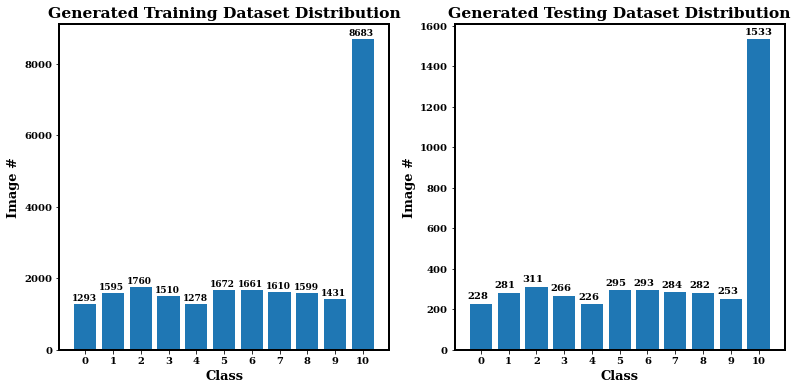

In [15]:
fig = plt.figure(figsize = (13, 6))
plt.subplot(1, 2, 1)
y , x = np.histogram(y_train_strip, bins = range(12))
plt.bar(range(11), y)
plt.title("Generated Training Dataset Distribution", weight = "bold")
plt.xlabel("Class", weight = "bold")
plt.xticks(range(11), weight = "bold")
plt.ylabel("Image #", weight = "bold")
for i, v, in enumerate(y):
    plt.text(i-.5, v+100, str(v), fontsize = 9)
plt.subplot(1, 2, 2)
y , x = np.histogram(y_test_strip, bins = range(12))
plt.bar(range(11), y)
plt.title("Generated Testing Dataset Distribution", weight = "bold")
plt.xlabel("Class", weight = "bold")
plt.xticks(range(11), weight = "bold")
plt.ylabel("Image #", weight = "bold")
for i, v, in enumerate(y):
    plt.text(i-.5, v+25, str(v), fontsize = 10)
plt.show()

#### Dataset Combination

In [16]:
X_train_mnist = X_train_mnist / 255; X_test_mnist = X_test_mnist / 255
X_train_mnist = X_train_mnist.astype(np.float32)
X_test_mnist = X_test_mnist.astype(np.float32)
X_train_strip = X_train_strip.astype(np.float32)
X_test_strip = X_test_strip.astype(np.float32)

X_train = np.concatenate((X_train_mnist, X_train_strip))
X_test = np.concatenate((X_test_mnist, X_test_strip))
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1)).astype('float32')
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1)).astype('float32')
y_train = np.concatenate((y_train_mnist, y_train_strip))
y_test = np.concatenate((y_test_mnist, y_test_strip))
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

num_classes = y_test.shape[1]
print("Num classes is " + str(num_classes))

(84092, 28, 28, 1)
(14252, 28, 28, 1)
(84092, 11)
(14252, 11)
Num classes is 11


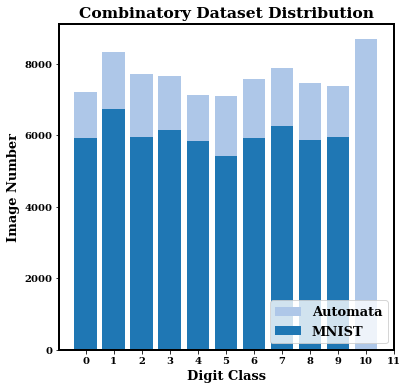

In [17]:
y , x = np.histogram(np.concatenate((y_train_mnist, y_train_strip)), bins = range(12))
plt.bar(range(11), y, color = cm.colors[1], label = "Automata")
y , x = np.histogram(y_train_mnist, bins = range(11))
plt.bar(range(10), y, color = cm.colors[0], label = "MNIST")
plt.title("Combinatory Dataset Distribution", weight = "bold")
plt.xlabel("Digit Class", weight = "bold")
plt.xticks(range(12), weight = "bold")
plt.ylabel("Image Number", weight = "bold")
plt.legend(loc=4)
plt.show()

The combinatory dataset contains an even amount of data for each class.

#### Model Summary

In [19]:
model = load_model("Deep_Learning_Classifier_v1.h5")

In [20]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 24, 24, 30)        780       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 30)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 10, 10, 15)        4065      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 5, 5, 15)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 5, 15)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 375)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)              

#### Model Training is performed on the MARCC cloud server for efficiency, result is thus not shown here.

In [18]:
# # convolutional neural network
# model = Sequential()
# model.add(Conv2D(30, (5, 5), input_shape = (28, 28, 1), activation = 'relu'))
# model.add(MaxPooling2D())
# model.add(Conv2D(15, (3, 3), activation = 'relu'))
# model.add(MaxPooling2D())
# model.add(Dropout(0.2))
# model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(Dense(100, activation='relu'))
# model.add(Dense(num_classes, activation = 'softmax'))
# # Compile model
# model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# filepath = "DigitClassifier_20201014_mod3.h5"

# checkpoint = ModelCheckpoint(filepath, monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'min')
# callbacks_list = [checkpoint]

# history = model.fit(X_train, y_train,\
#                     validation_data = (X_test, y_test), epochs = 20, batch_size = 200,\
#                     callbacks = callbacks_list)

#### Model Evaluation - 98% accuracy

In [21]:
model.evaluate(X_test, y_test)

446/446 [==============================] - 1s 3ms/step - loss: 0.0656 - accuracy: 0.9802


[0.06561373174190521, 0.9802132844924927]